In [40]:
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import time

In [101]:
# current italy
# Italy
df_italy = pd.read_csv('covid_italy_sim.csv', index_col=0)
df_italy

# current infected
df_i = df_italy['current_case']
# death count
df_d = df_italy['total_death']
# recovered count
df_r = df_italy['total_recovered']


#ax = df_i.plot(grid=True, title='Population overview in Italy (real data)', label='Infected', figsize=(18,8), legend=True)
#df_d.plot(grid=True, ax=ax, label='Death', figsize=(18,8), legend=True)
#df_r.plot(grid=True, ax=ax, label='Recovered', figsize=(18,8), legend=True)
df_i

date
22/02/2020 20:20        75
23/02/2020 20:20       152
24/02/2020 20:20       220
25/02/2020 20:20       310
26/02/2020 20:20       455
                     ...  
02/05/2021 20:20    430904
03/05/2021 20:20    423555
04/05/2021 20:20    413883
05/05/2021 20:20    407120
06/05/2021 20:20    402797
Name: current_case, Length: 440, dtype: int64

In [102]:
Ilist_i = df_i.to_numpy()
Rlist_i = df_r.to_numpy()
Dlist_i = df_d.to_numpy()

global Ilist_i, Rlist_i, Dlist_i;

In [105]:
# current infected
df_i = df_italy['current_case'].iloc[20:420]
# death count
df_d = df_italy['total_death'].iloc[20:420]
# recovered count
df_r = df_italy['total_recovered'].iloc[20:420]

Ilist_m = df_i.to_numpy()
Rlist_m = df_r.to_numpy()
Dlist_m = df_d.to_numpy()

global Ilist_m, Rlist_m, Dlist_m;

## Test with window size & Results

In [59]:
# current infected
df_i = df_italy['current_case'].iloc[:20]
# death count
df_d = df_italy['total_death'].iloc[:20]
# recovered count
df_r = df_italy['total_recovered'].iloc[:20]

Ilist_0 = df_i.to_numpy()
Rlist_0 = df_r.to_numpy()
Dlist_0 = df_d.to_numpy()

global Ilist_0, Rlist_0, Dlist_0;

In [90]:
# 440 days, window = 20 days
# 22 iterations
# first 20 days

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize

def SEAIQRD_model(Y,t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# calculate parameters
def fit_odeint_SEAIQRD(t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    return integrate.odeint(SEAIQRD_model, ini, t, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))

# loss function
def loss(para, i):
    beta = para[0]
    delta = para[1]
    mu = para[2]
    kappa = para[3]
    epsilon = para[4]
    gamma = para[5]
    sigma = para[6]
    lamb = para[7]
    
    #T = np.arange(0,len(Ilist_i))
    T = np.arange(0,20)
    I0 = Ilist_0[0]
    E0 = I0*5
    Di0 = I0*0.8
    # assumes no one get quarantined at first
    Q0 = I0*0.7
    R0 = Rlist_0[0]
    D0 = Dlist_0[0]
    population = 60e6
    S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
    ini =[S0, E0, I0, Di0, Q0, D0, R0]


    fit_seaiqrd = integrate.odeint(SEAIQRD_model, ini, T, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
    diffI = fit_seaiqrd[:,2] - Ilist_0[:20]
    diffD = fit_seaiqrd[:,5] - Dlist_0[:20]
    fitloss=1000*np.dot(diffI.T,diffI)+1*np.dot(diffD.T,diffD)
    return fitloss


# initiate the model
#T= np.arange(0,len(Ilist_i)) # time span


T = np.arange(0,20)
I0 = Ilist_0[0]
E0 = I0*5
Di0 = I0*0.8
# assumes no one get quarantined at first
Q0 = I0*0.7
R0 = Rlist_0[0]
D0 = Dlist_0[0]
population = 60e6
S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
ini =[S0, E0, I0, Di0, Q0, D0, R0]
#  optimize the model
methods=['Nelder-Mead','SLSQP','L-BFGS-B','COBYLA','Powell','TNC','trust-constr']

# start with some guesses of parameters to find the best parameter
beta = 10
delta = 0.3
mu = 0.1
kappa = 0.3
epsilon = 0.3
gamma = 0.8
sigma = 0.1
lamb = 0.1
para = [beta,delta,mu,kappa,epsilon,gamma,sigma,lamb]

method_name = methods[2]
para= optimize.minimize(loss, para, i, method=method_name,bounds=[(0,8),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)])

# get the fitting data of model
popt = para.x
# theoritical data with future expectation
fitted = fit_odeint_SEAIQRD(np.array(list(range(1,21))), *popt)
infect = fitted[:,2]
death = fitted[:,5]
    
total_i = infect
total_d = death
    
    # plot the result
    #plt.figure(figsize=(8,6))
    #plt.plot(np.arange(0,20),fitted[:,0],'b-',label ='S')
    #plt.plot(np.arange(0,20),fitted[:,1],'y-',label = 'E')
    #plt.plot(np.arange(0,20),infect,'c-',label = 'I')
    #plt.plot(np.arange(0,20),fitted[:,3],'k-',label = 'Di')
    #plt.plot(np.arange(0,20),fitted[:,4],'r-',label = 'Q')
    #plt.plot(np.arange(0,20),death,'m-',label = 'D')
    #plt.plot(np.arange(0,20),fitted[:,6],'g-',label = 'R')
    #plt.scatter(T,Ilist_i[i:i+20],label='Actural I')
    #plt.scatter(T,Dlist_i[i:i+20],label='Actural D')
    #plt.scatter(T,Rlist,label='Actural R')
    #plt.xlabel('days')
    #plt.ylabel('Population')
    #plt.grid()
    #plt.title('SEIDiQRD model Italy simulation '+str(i)+'-'+str(i+20)+' day')
    #plt.legend()
    #plt.savefig("SEIDiQRD_Italy"+str(i)+".png")
  
print('0-20 days parameters: ',popt)

0-20 days parameters:  [0.23881202 0.8627515  0.         0.98481719 0.33053031 0.
 0.         0.        ]


In [91]:
total_i = infect
total_d = death

In [107]:
# 20 - 420 days
def SEAIQRD_model(Y,t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# calculate parameters
def fit_odeint_SEAIQRD(t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    return integrate.odeint(SEAIQRD_model, ini, t, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))

# loss function
def loss(para, i):
    beta = para[0]
    delta = para[1]
    mu = para[2]
    kappa = para[3]
    epsilon = para[4]
    gamma = para[5]
    sigma = para[6]
    lamb = para[7]
    
    #T = np.arange(0,len(Ilist_i))
    T = np.arange(0,20)
    I0 = Ilist_m[0+i]
    E0 = I0*5
    Di0 = I0*0.8
    # assumes no one get quarantined at first
    Q0 = I0*0.7
    R0 = Rlist_m[0+i]
    D0 = Dlist_m[0+i]
    population = 60e6
    S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
    ini =[S0, E0, I0, Di0, Q0, D0, R0]


    fit_seaiqrd = integrate.odeint(SEAIQRD_model, ini, T, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
    diffI = fit_seaiqrd[:,2] - Ilist_m[i:i+20]
    diffD = fit_seaiqrd[:,5] - Dlist_m[i:i+20]
    fitloss=1000*np.dot(diffI.T,diffI)+1*np.dot(diffD.T,diffD)
    #fitloss=np.dot(diffI.T,diffI)
    #fitloss=np.dot(diffD.T,diffD)
    return fitloss


# initiate the model
#T= np.arange(0,len(Ilist_i)) # time span


for i in range(0, len(Ilist_m), 20):
    T = np.arange(0,20)
    I0 = Ilist_m[0+i]
    E0 = I0*5
    Di0 = I0*0.8
# assumes no one get quarantined at first
    Q0 = I0*0.7
    R0 = Rlist_m[0+i]
    D0 = Dlist_m[0+i]
    population = 60e6
    S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
    ini =[S0, E0, I0, Di0, Q0, D0, R0]
#  optimize the model
    methods=['Nelder-Mead','SLSQP','L-BFGS-B','COBYLA','Powell','TNC','trust-constr']

# start with some guesses of parameters to find the best parameter
    beta = 10
    delta = 0.3
    mu = 0.1
    kappa = 0.3
    epsilon = 0.3
    gamma = 0.8
    sigma = 0.1
    lamb = 0.1
    para = [beta,delta,mu,kappa,epsilon,gamma,sigma,lamb]

    method_name = methods[2]
    para= optimize.minimize(loss, para, i, method=method_name,bounds=[(0,8),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)])

# get the fitting data of model
    popt = para.x
# theoritical data with future expectation
    fitted = fit_odeint_SEAIQRD(np.array(list(range(1,21))), *popt)
    infect = fitted[:,2]
    death = fitted[:,5]
    
    total_i = [*total_i, *infect]
    total_d = [*total_d, *death]
    
    # plot the result
    #plt.figure(figsize=(8,6))
    #plt.plot(np.arange(0,20),fitted[:,0],'b-',label ='S')
    #plt.plot(np.arange(0,20),fitted[:,1],'y-',label = 'E')
    #plt.plot(np.arange(0,20),infect,'c-',label = 'I')
    #plt.plot(np.arange(0,20),fitted[:,3],'k-',label = 'Di')
    #plt.plot(np.arange(0,20),fitted[:,4],'r-',label = 'Q')
    #plt.plot(np.arange(0,20),death,'m-',label = 'D')
    #plt.plot(np.arange(0,20),fitted[:,6],'g-',label = 'R')
    #plt.scatter(T,Ilist_i[i:i+20],label='Actural I')
    #plt.scatter(T,Dlist_i[i:i+20],label='Actural D')
    #plt.scatter(T,Rlist,label='Actural R')
    #plt.xlabel('days')
    #plt.ylabel('Population')
    #plt.grid()
    #plt.title('SEIDiQRD model Italy simulation '+str(i)+'-'+str(i+20)+' day')
    #plt.legend()
    #plt.savefig("SEIDiQRD_Italy"+str(i)+".png")
    r0 = (popt[0]+ popt[2]/(popt[3]+popt[7]) + (popt[2]*popt[3]/(popt[4]+popt[5])))/(popt[2]+popt[6])
    print(str(i+20),' - ',str(i+40),'parameters: ',popt)
    print(str(i+20),' - ',str(i+40),'r0: ',r0)
    
    i=i+20

20  -  40 parameters:  [2.33198968 0.67278914 1.         0.11050382 0.1520071  0.96802753
 1.         0.996015  ]
20  -  40 r0:  1.6671929760454234
40  -  60 parameters:  [2.16714326 0.41216744 0.99986661 0.0517699  0.06585739 0.9392657
 1.         0.99999742]
40  -  60 r0:  1.5847538098741387
60  -  80 parameters:  [2.0062776  0.40512931 1.         0.23458706 0.01130431 0.94893185
 1.         0.76659344]
60  -  80 r0:  1.6246999564369327
80  -  100 parameters:  [1.86010962 0.38438462 1.         0.2379603  0.00841903 0.94576196
 1.         0.9256647 ]
80  -  100 r0:  1.4844399868625837
100  -  120 parameters:  [1.81917421 0.40599356 1.         0.04179299 0.01589627 0.9618035
 1.         0.81525655]
100  -  120 r0:  1.5143570694987312
120  -  140 parameters:  [0.4664058  0.10926803 0.22925779 0.         0.4816385  1.
 0.37693765 1.        ]
120  -  140 r0:  1.147589610856611
140  -  160 parameters:  [0.16434547 0.02377977 0.12112983 0.99977919 0.00588156 1.
 0.01580383 1.        ]
140  

In [280]:
# current infected
df_i = df_italy['current_case'].iloc[420:440]
# death count
df_d = df_italy['total_death'].iloc[420:440]
# recovered count
df_r = df_italy['total_recovered'].iloc[420:440]

Ilist_t = df_i.to_numpy()
Rlist_t = df_r.to_numpy()
Dlist_t = df_d.to_numpy()

global Ilist_t, Rlist_t, Dlist_t;

In [281]:
# 420-440 days
def SEAIQRD_model(Y,t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# calculate parameters
def fit_odeint_SEAIQRD(t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    return integrate.odeint(SEAIQRD_model, ini, t, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))

# loss function
def loss(para, i):
    beta = para[0]
    delta = para[1]
    mu = para[2]
    kappa = para[3]
    epsilon = para[4]
    gamma = para[5]
    sigma = para[6]
    lamb = para[7]
    
    #T = np.arange(0,len(Ilist_i))
    T = np.arange(0,20)
    I0 = Ilist_t[0]
    E0 = I0*5
    Di0 = I0*0.8
    # assumes no one get quarantined at first
    Q0 = I0*0.7
    R0 = Rlist_t[0]
    D0 = Dlist_t[0]
    population = 60e6
    S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
    ini =[S0, E0, I0, Di0, Q0, D0, R0]


    fit_seaiqrd = integrate.odeint(SEAIQRD_model, ini, T, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
    diffI = fit_seaiqrd[:,2] - Ilist_t[:20]
    diffD = fit_seaiqrd[:,5] - Dlist_t[:20]
    fitloss=1000*np.dot(diffI.T,diffI)+10*np.dot(diffD.T,diffD)
    return fitloss


# initiate the model
#T= np.arange(0,len(Ilist_i)) # time span


T = np.arange(0,20)
I0 = Ilist_t[0]
E0 = I0*5
Di0 = I0*0.8
# assumes no one get quarantined at first
Q0 = I0*0.7
R0 = Rlist_t[0]
D0 = Dlist_t[0]
population = 60e6
S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
ini =[S0, E0, I0, Di0, Q0, D0, R0]
#  optimize the model
methods=['Nelder-Mead','SLSQP','L-BFGS-B','COBYLA','Powell','TNC','trust-constr']

# start with some guesses of parameters to find the best parameter
beta = 10
delta = 0.3
mu = 0.1
kappa = 0.3
epsilon = 0.3
gamma = 0.8
sigma = 0.1
lamb = 0.1
para = [beta,delta,mu,kappa,epsilon,gamma,sigma,lamb]

method_name = methods[2]
para= optimize.minimize(loss, para, i, method=method_name,bounds=[(0,8),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)])

# get the fitting data of model
popt = para.x
# theoritical data with future expectation
fitted = fit_odeint_SEAIQRD(np.array(list(range(1,21+5))), *popt)
infect = fitted[:,2]
death = fitted[:,5]
    
total_i = [*total_i, *infect]
total_d = [*total_d, *death]
    
    
print('420-440 days parameters: ',popt)

420-440 days parameters:  [3.43912057e-01 6.87434356e-02 1.81971034e-01 7.30853691e-01
 7.35588739e-04 1.10691294e-01 1.79209373e-01 9.72879685e-01]


In [284]:
df_italy_ev = pd.read_csv('covid_italy.csv', index_col=0)
df_italy_ev

# current infected
df_i = df_italy_ev['current_case']
# death count
df_d = df_italy_ev['total_death']
# recovered count
df_r = df_italy_ev['total_recovered']

r2_i = df_italy_ev['current_case'].iloc[420:445]
r2_d = df_italy_ev['total_death'].iloc[420:445]

In [283]:
infect[20:25]

array([401058.81060159, 396332.53912615, 391617.51103329, 386915.16023454,
       382226.90484253])

In [285]:
r2_i[20:25]

date
07/05/2021 20:20    397477
08/05/2021 20:20    390032
09/05/2021 20:20    383766
10/05/2021 20:20    373582
11/05/2021 20:20    363770
Name: current_case, dtype: int64

In [254]:
from sklearn.metrics import r2_score
r2_score(r2_i, infect)

0.9789901189829986

In [255]:
r2_score(r2_d, death)

0.9980372231572756

In [256]:
r2_score(r2_i[20:25], infect[20:25])

0.10899484658430736

In [257]:
r2_score(r2_d[20:25], death[20:25])

0.9428934647093786

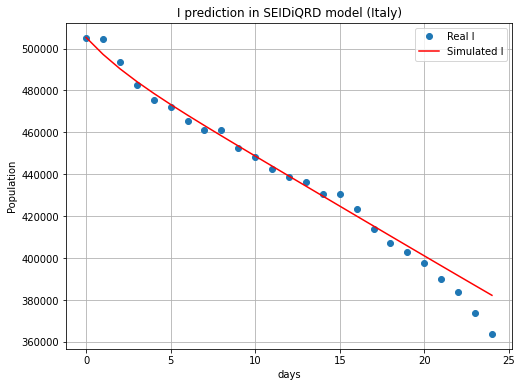

In [260]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,25),r2_i,'o',label = 'Real I')
plt.plot(np.arange(0,25),infect,'r-',label='Simulated I')
plt.grid()
plt.xlabel('days')
plt.ylabel('Population')
plt.title('I prediction in SEIDiQRD model (Italy)')
plt.legend()
plt.show()

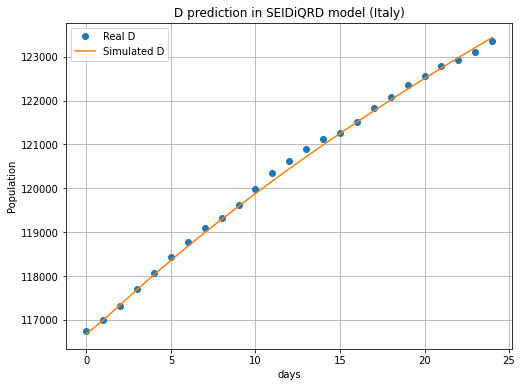

In [261]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,25),r2_d,'o',label = 'Real D')
plt.plot(np.arange(0,25),death,label='Simulated D')
plt.grid()
plt.xlabel('days')
plt.ylabel('Population')
plt.title('D prediction in SEIDiQRD model (Italy)')
plt.legend()
plt.show()

## Results (Italy)

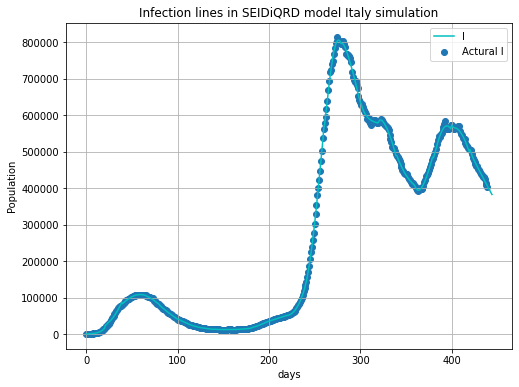

In [103]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,445),total_i,'c-',label = 'I')
plt.scatter(np.arange(0,440),Ilist_i,label='Actural I')
plt.grid()
plt.xlabel('days')
plt.ylabel('Population')
plt.title('Infection lines in SEIDiQRD model Italy simulation')
plt.legend()
plt.show()

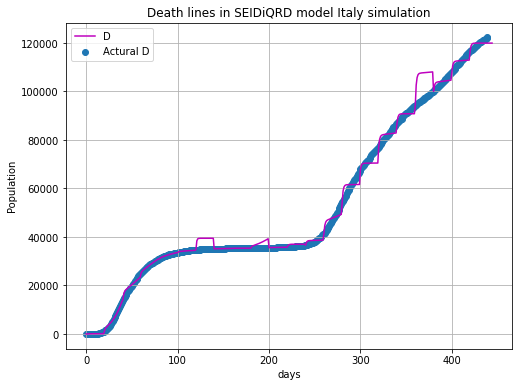

In [104]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,445),total_d,'m-',label = 'D')
plt.scatter(np.arange(0,440),Dlist_i,label='Actural D')
plt.grid()
plt.xlabel('days')
plt.ylabel('Population')
plt.title('Death lines in SEIDiQRD model Italy simulation')
plt.legend()
plt.show()

## France simulation

In [134]:
# France
df_france = pd.read_csv('covid_france.csv', index_col=0)
df_france

# current infected
df_i = df_france['current_case'].iloc[:440]
# death count
df_d = df_france['total_death'].iloc[:440]
# recovered count
df_r = df_france['total_recovered'].iloc[:440]

Ilist_i = df_i.to_numpy()
Rlist_i = df_r.to_numpy()
Dlist_i = df_d.to_numpy()

global Ilist_i, Rlist_i, Dlist_i;

In [135]:
# current infected
df_i = df_france['current_case'].iloc[20:420]
# death count
df_d = df_france['total_death'].iloc[20:420]
# recovered count
df_r = df_france['total_recovered'].iloc[20:420]

Ilist_m = df_i.to_numpy()
Rlist_m = df_r.to_numpy()
Dlist_m = df_d.to_numpy()

global Ilist_m, Rlist_m, Dlist_m;

In [136]:
# current infected
df_i = df_france['current_case'].iloc[:20]
# death count
df_d = df_france['total_death'].iloc[:20]
# recovered count
df_r = df_france['total_recovered'].iloc[:20]

Ilist_0 = df_i.to_numpy()
Rlist_0 = df_r.to_numpy()
Dlist_0 = df_d.to_numpy()

global Ilist_0, Rlist_0, Dlist_0;

In [137]:
# 440 days, window = 20 days
# 22 iterations
# first 20 days

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize

def SEAIQRD_model(Y,t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# calculate parameters
def fit_odeint_SEAIQRD(t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    return integrate.odeint(SEAIQRD_model, ini, t, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))

# loss function
def loss(para, i):
    beta = para[0]
    delta = para[1]
    mu = para[2]
    kappa = para[3]
    epsilon = para[4]
    gamma = para[5]
    sigma = para[6]
    lamb = para[7]
    
    #T = np.arange(0,len(Ilist_i))
    T = np.arange(0,20)
    I0 = Ilist_0[0]
    E0 = I0*5
    Di0 = I0*0.8
    # assumes no one get quarantined at first
    Q0 = I0*0.7
    R0 = Rlist_0[0]
    D0 = Dlist_0[0]
    population = 67e6
    S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
    ini =[S0, E0, I0, Di0, Q0, D0, R0]


    fit_seaiqrd = integrate.odeint(SEAIQRD_model, ini, T, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
    diffI = fit_seaiqrd[:,2] - Ilist_0[:20]
    diffD = fit_seaiqrd[:,5] - Dlist_0[:20]
    fitloss=1000*np.dot(diffI.T,diffI)+1*np.dot(diffD.T,diffD)
    return fitloss


# initiate the model
#T= np.arange(0,len(Ilist_i)) # time span
T = np.arange(0,20)
I0 = Ilist_0[0]
E0 = I0*5
Di0 = I0*0.8
# assumes no one get quarantined at first
Q0 = I0*0.7
R0 = Rlist_0[0]
D0 = Dlist_0[0]
population = 67e6
S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
ini =[S0, E0, I0, Di0, Q0, D0, R0]
#  optimize the model
methods=['Nelder-Mead','SLSQP','L-BFGS-B','COBYLA','Powell','TNC','trust-constr']

# start with some guesses of parameters to find the best parameter
beta = 10
delta = 0.3
mu = 0.1
kappa = 0.3
epsilon = 0.3
gamma = 0.8
sigma = 0.1
lamb = 0.1
para = [beta,delta,mu,kappa,epsilon,gamma,sigma,lamb]

method_name = methods[2]
para= optimize.minimize(loss, para, i, method=method_name,bounds=[(0,8),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)])

# get the fitting data of model
popt = para.x
# theoritical data with future expectation
fitted = fit_odeint_SEAIQRD(np.array(list(range(1,21))), *popt)
infect = fitted[:,2]
death = fitted[:,5]
    
total_i = infect
total_d = death
  
print('0-20 days parameters: ',popt)

0-20 days parameters:  [8.88029752e-01 4.64301393e-01 1.58245823e-01 9.99969406e-01
 8.23821898e-01 0.00000000e+00 1.58326209e-01 2.00031244e-04]


In [138]:
total_i = infect
total_d = death

In [139]:
# 20 - 420 days
def SEAIQRD_model(Y,t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# calculate parameters
def fit_odeint_SEAIQRD(t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    return integrate.odeint(SEAIQRD_model, ini, t, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))

# loss function
def loss(para, i):
    beta = para[0]
    delta = para[1]
    mu = para[2]
    kappa = para[3]
    epsilon = para[4]
    gamma = para[5]
    sigma = para[6]
    lamb = para[7]
    
    #T = np.arange(0,len(Ilist_i))
    T = np.arange(0,20)
    I0 = Ilist_m[0+i]
    E0 = I0*5
    Di0 = I0*0.8
    # assumes no one get quarantined at first
    Q0 = I0*0.7
    R0 = Rlist_m[0+i]
    D0 = Dlist_m[0+i]
    population = 60e6
    S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
    ini =[S0, E0, I0, Di0, Q0, D0, R0]


    fit_seaiqrd = integrate.odeint(SEAIQRD_model, ini, T, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
    diffI = fit_seaiqrd[:,2] - Ilist_m[i:i+20]
    diffD = fit_seaiqrd[:,5] - Dlist_m[i:i+20]
    fitloss=1000*np.dot(diffI.T,diffI)+1*np.dot(diffD.T,diffD)
    #fitloss=np.dot(diffI.T,diffI)
    #fitloss=np.dot(diffD.T,diffD)
    return fitloss


# initiate the model
#T= np.arange(0,len(Ilist_i)) # time span


for i in range(0, len(Ilist_m), 20):
    T = np.arange(0,20)
    I0 = Ilist_m[0+i]
    E0 = I0*5
    Di0 = I0*0.8
# assumes no one get quarantined at first
    Q0 = I0*0.7
    R0 = Rlist_m[0+i]
    D0 = Dlist_m[0+i]
    population = 60e6
    S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
    ini =[S0, E0, I0, Di0, Q0, D0, R0]
#  optimize the model
    methods=['Nelder-Mead','SLSQP','L-BFGS-B','COBYLA','Powell','TNC','trust-constr']

# start with some guesses of parameters to find the best parameter
    beta = 10
    delta = 0.3
    mu = 0.1
    kappa = 0.3
    epsilon = 0.3
    gamma = 0.8
    sigma = 0.1
    lamb = 0.1
    para = [beta,delta,mu,kappa,epsilon,gamma,sigma,lamb]

    method_name = methods[2]
    para= optimize.minimize(loss, para, i, method=method_name,bounds=[(0,8),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)])

# get the fitting data of model
    popt = para.x
# theoritical data with future expectation
    fitted = fit_odeint_SEAIQRD(np.array(list(range(1,21))), *popt)
    infect = fitted[:,2]
    death = fitted[:,5]
    
    total_i = [*total_i, *infect]
    total_d = [*total_d, *death]
    

    r0 = (popt[0]+ popt[2]/(popt[3]+popt[7]) + (popt[2]*popt[3]/(popt[4]+popt[5])))/(popt[2]+popt[6])
    print(str(i+20),' - ',str(i+40),'parameters: ',popt)
    print(str(i+20),' - ',str(i+40),'r0: ',r0)
    
    i=i+20

20  -  40 parameters:  [2.33540952 0.66155781 1.         0.10020281 0.1758427  0.97902094
 1.         0.79453605]
20  -  40 r0:  1.7699099943254928
40  -  60 parameters:  [2.05196373 0.43594846 1.         0.20066284 0.06874348 0.94507487
 1.         0.75476697]
40  -  60 r0:  1.6482704448256855
60  -  80 parameters:  [1.88272694 0.45338125 1.         0.05968013 0.04878922 0.95787216
 1.         0.99999998]
60  -  80 r0:  1.4428465793553213
80  -  100 parameters:  [1.03343578 0.20150148 0.6709386  0.01991107 0.         0.97889888
 0.67213277 0.92854709]
80  -  100 r0:  1.3063208278522973
100  -  120 parameters:  [1.89895405 0.44065523 1.         0.34440104 0.00900825 0.96583914
 1.         0.76864462]
100  -  120 r0:  1.5753384638734806
120  -  140 parameters:  [6.97530944e-01 1.31039704e-01 3.09766533e-01 1.70537380e-04
 2.70167696e-02 9.99994060e-01 3.21239523e-01 8.21657043e-01]
120  -  140 r0:  1.7028463746814768
140  -  160 parameters:  [3.71923284e-01 2.68794820e-02 1.28422793e-02

<ipython-input-139-ba18fc6892b4>:96: RuntimeWarning: divide by zero encountered in double_scalars
  r0 = (popt[0]+ popt[2]/(popt[3]+popt[7]) + (popt[2]*popt[3]/(popt[4]+popt[5])))/(popt[2]+popt[6])


160  -  180 parameters:  [5.28081171e-01 7.67261170e-03 0.00000000e+00 1.02293395e-05
 6.83669114e-03 9.99997033e-01 0.00000000e+00 9.82535391e-01]
160  -  180 r0:  inf
180  -  200 parameters:  [2.05540036e+00 3.73918162e-01 8.58258903e-01 7.18514675e-10
 4.93503763e-03 9.99997567e-01 8.67165619e-01 9.99998237e-01]
180  -  200 r0:  1.6886631313063796
200  -  220 parameters:  [2.07716903 0.34678208 0.88664326 0.         0.00684764 0.95753653
 0.8884231  0.99999982]
200  -  220 r0:  1.6696910780809313
220  -  240 parameters:  [1.85055185 0.00217821 0.00239186 0.         0.01278641 0.94633141
 0.00238569 0.80138573]
220  -  240 r0:  387.96836531677195
240  -  260 parameters:  [1.32429707 0.18450499 0.44511582 0.04150386 0.01032998 0.96531862
 0.44611901 0.99999523]
240  -  260 r0:  1.9866953914904295
260  -  280 parameters:  [2.10863678 0.35327712 0.91070158 0.04797215 0.00660242 0.96109298
 0.91447887 0.76215183]
260  -  280 r0:  1.795950868419275
280  -  300 parameters:  [0.98118147 0.0

In [286]:
# current infected
df_i = df_france['current_case'].iloc[420:440]
# death count
df_d = df_france['total_death'].iloc[420:440]
# recovered count
df_r = df_france['total_recovered'].iloc[420:440]

Ilist_t = df_i.to_numpy()
Rlist_t = df_r.to_numpy()
Dlist_t = df_d.to_numpy()

global Ilist_t, Rlist_t, Dlist_t;

In [287]:
# 420-440 days
def SEAIQRD_model(Y,t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# calculate parameters
def fit_odeint_SEAIQRD(t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    return integrate.odeint(SEAIQRD_model, ini, t, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))

# loss function
def loss(para, i):
    beta = para[0]
    delta = para[1]
    mu = para[2]
    kappa = para[3]
    epsilon = para[4]
    gamma = para[5]
    sigma = para[6]
    lamb = para[7]
    
    #T = np.arange(0,len(Ilist_i))
    T = np.arange(0,20)
    I0 = Ilist_t[0]
    E0 = I0*5
    Di0 = I0*0.8
    # assumes no one get quarantined at first
    Q0 = Di0*0.7
    R0 = Rlist_t[0]
    D0 = Dlist_t[0]
    population = 67e6
    S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
    ini =[S0, E0, I0, Di0, Q0, D0, R0]


    fit_seaiqrd = integrate.odeint(SEAIQRD_model, ini, T, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
    diffI = fit_seaiqrd[:,2] - Ilist_t[:20]
    diffD = fit_seaiqrd[:,5] - Dlist_t[:20]
    fitloss=1000*np.dot(diffI.T,diffI)+10*np.dot(diffD.T,diffD)
    return fitloss


# initiate the model
#T= np.arange(0,len(Ilist_i)) # time span


T = np.arange(0,20)
I0 = Ilist_t[0]
E0 = I0*5
Di0 = I0*0.8
# assumes no one get quarantined at first
Q0 = I0*0.7
R0 = Rlist_t[0]
D0 = Dlist_t[0]
population = 67e6
S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
ini =[S0, E0, I0, Di0, Q0, D0, R0]
#  optimize the model
methods=['Nelder-Mead','SLSQP','L-BFGS-B','COBYLA','Powell','TNC','trust-constr']

# start with some guesses of parameters to find the best parameter
beta = 10
delta = 0.3
mu = 0.1
kappa = 0.3
epsilon = 0.3
gamma = 0.8
sigma = 0.1
lamb = 0.1
para = [beta,delta,mu,kappa,epsilon,gamma,sigma,lamb]

method_name = methods[2]
para= optimize.minimize(loss, para, i, method=method_name,bounds=[(0,8),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)])

# get the fitting data of model
popt = para.x
# theoritical data with future expectation
fitted = fit_odeint_SEAIQRD(np.array(list(range(1,21+5))), *popt)
infect = fitted[:,2]
death = fitted[:,5]
    
total_i = [*total_i, *infect]
total_d = [*total_d, *death]
    
    
print('420-440 days parameters: ',popt)
r0 = (popt[0]+ popt[2]/(popt[3]+popt[7]) + (popt[2]*popt[3]/(popt[4]+popt[5])))/(popt[2]+popt[6])
print(str(i+20),' - ',str(i+40),'r0: ',r0)

420-440 days parameters:  [1.11980346 0.20524937 0.51026988 1.         0.00142108 0.98803374
 0.51765546 0.9963387 ]
420  -  440 r0:  1.839739102337236


In [288]:
df_france_ev = pd.read_csv('covid_france.csv', index_col=0)
df_france_ev

# current infected
df_i = df_france_ev['current_case']
# death count
df_d = df_france_ev['total_death']
# recovered count
df_r = df_france_ev['total_recovered']

r2_i = df_france_ev['current_case'].iloc[420:445]
r2_d = df_france_ev['total_death'].iloc[420:445]

In [290]:
r2_d[20:25]

date
12/05/2021 20:20    107119
13/05/2021 20:20    107250
14/05/2021 20:20    107423
15/05/2021 20:20    107545
16/05/2021 20:20    107636
Name: total_death, dtype: int64

In [291]:
death[20:25]

array([106775.25357041, 106923.95265268, 107067.43575082, 107205.75128805,
       107338.96095584])

In [289]:
from sklearn.metrics import r2_score
r2_score(r2_i, infect)

0.987573936980914

In [266]:
r2_score(r2_d, death)


0.9750476360048421

In [267]:
r2_score(r2_i[20:25], infect[20:25])


0.7188737026749694

In [268]:
r2_score(r2_d[20:25], death[20:25])

-2.103719527464062

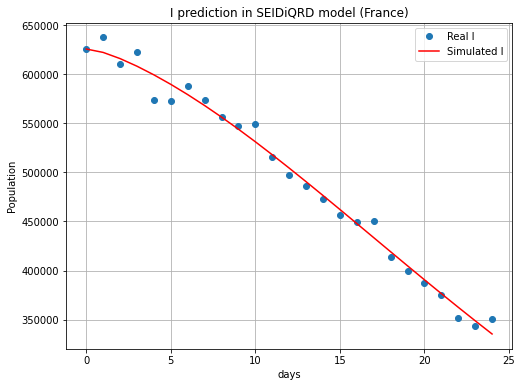

In [269]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,25),r2_i,'o',label = 'Real I')
plt.plot(np.arange(0,25),infect,'r-',label='Simulated I')
plt.grid()
plt.xlabel('days')
plt.ylabel('Population')
plt.title('I prediction in SEIDiQRD model (France)')
plt.legend()
plt.show()


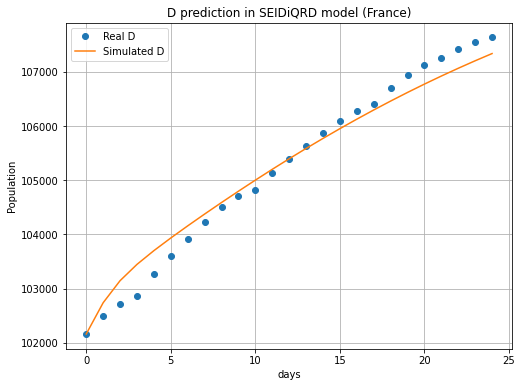

In [270]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,25),r2_d,'o',label = 'Real D')
plt.plot(np.arange(0,25),death,label='Simulated D')
plt.grid()
plt.xlabel('days')
plt.ylabel('Population')
plt.title('D prediction in SEIDiQRD model (France)')
plt.legend()
plt.show()


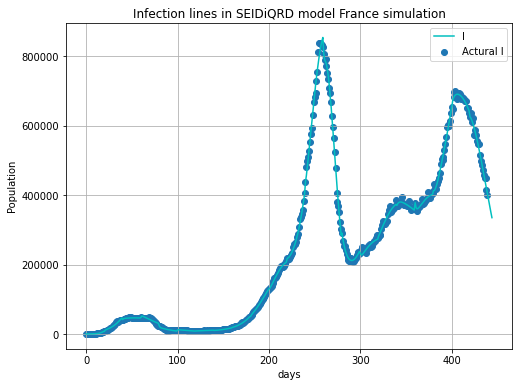

In [144]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,445),total_i,'c-',label = 'I')
plt.scatter(np.arange(0,440),Ilist_i,label='Actural I')
plt.grid()
plt.xlabel('days')
plt.ylabel('Population')
plt.title('Infection lines in SEIDiQRD model France simulation')
plt.legend()
plt.show()

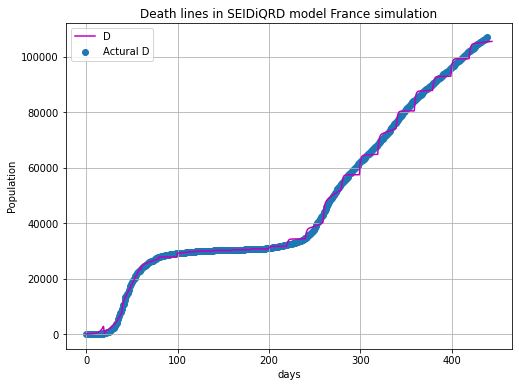

In [145]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,445),total_d,'m-',label = 'D')
plt.scatter(np.arange(0,440),Dlist_i,label='Actural D')
plt.grid()
plt.xlabel('days')
plt.ylabel('Population')
plt.title('Death lines in SEIDiQRD model France simulation')
plt.legend()
plt.show()

## UK simulation

In [163]:
# uk
df_uk = pd.read_csv('covid_uk.csv', index_col=0)
df_uk

# current infected
df_i = df_uk['current_case'].iloc[:440]
# death count
df_d = df_uk['total_death'].iloc[:440]

Ilist_i = df_i.to_numpy()
Dlist_i = df_d.to_numpy()

global Ilist_i, Dlist_i;

In [164]:
# current infected
df_i = df_uk['current_case'].iloc[20:420]
# death count
df_d = df_uk['total_death'].iloc[20:420]

Ilist_m = df_i.to_numpy()
Dlist_m = df_d.to_numpy()

global Ilist_m, Dlist_m;

In [292]:
# current infected
df_i = df_uk['current_case'].iloc[:20]
# death count
df_d = df_uk['total_death'].iloc[:20]

Ilist_0 = df_i.to_numpy()
Dlist_0 = df_d.to_numpy()

global Ilist_0, Dlist_0;

In [166]:
# 440 days, window = 20 days
# 22 iterations
# first 20 days

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize

def SEAIQRD_model(Y,t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# calculate parameters
def fit_odeint_SEAIQRD(t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    return integrate.odeint(SEAIQRD_model, ini, t, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))

# loss function
def loss(para, i):
    beta = para[0]
    delta = para[1]
    mu = para[2]
    kappa = para[3]
    epsilon = para[4]
    gamma = para[5]
    sigma = para[6]
    lamb = para[7]
    
    #T = np.arange(0,len(Ilist_i))
    T = np.arange(0,20)
    I0 = Ilist_0[0]
    E0 = I0*5
    Di0 = I0*0.8
    # assumes no one get quarantined at first
    Q0 = I0*0.7
    R0 = 1
    D0 = Dlist_0[0]
    population = 66e6
    S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
    ini =[S0, E0, I0, Di0, Q0, D0, R0]


    fit_seaiqrd = integrate.odeint(SEAIQRD_model, ini, T, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
    diffI = fit_seaiqrd[:,2] - Ilist_0[:20]
    diffD = fit_seaiqrd[:,5] - Dlist_0[:20]
    fitloss=1000*np.dot(diffI.T,diffI)+1*np.dot(diffD.T,diffD)
    return fitloss


# initiate the model
#T= np.arange(0,len(Ilist_i)) # time span
T = np.arange(0,20)
I0 = Ilist_0[0]
E0 = I0*5
Di0 = I0*0.8
# assumes no one get quarantined at first
Q0 = I0*0.7
R0 = 1
D0 = Dlist_0[0]
population = 66e6
S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
ini =[S0, E0, I0, Di0, Q0, D0, R0]
#  optimize the model
methods=['Nelder-Mead','SLSQP','L-BFGS-B','COBYLA','Powell','TNC','trust-constr']

# start with some guesses of parameters to find the best parameter
beta = 10
delta = 0.3
mu = 0.1
kappa = 0.3
epsilon = 0.3
gamma = 0.8
sigma = 0.1
lamb = 0.1
para = [beta,delta,mu,kappa,epsilon,gamma,sigma,lamb]

method_name = methods[2]
para= optimize.minimize(loss, para, i, method=method_name,bounds=[(0,8),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)])

# get the fitting data of model
popt = para.x
# theoritical data with future expectation
fitted = fit_odeint_SEAIQRD(np.array(list(range(1,21))), *popt)
infect = fitted[:,2]
death = fitted[:,5]
    
total_i = infect
total_d = death
  
print('0-20 days parameters: ',popt)

0-20 days parameters:  [0.34819328 0.39191916 0.         0.86637035 0.86716935 0.02064335
 0.         0.99996965]


In [167]:
total_i = infect
total_d = death

In [168]:
# 20 - 420 days
def SEAIQRD_model(Y,t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# calculate parameters
def fit_odeint_SEAIQRD(t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    return integrate.odeint(SEAIQRD_model, ini, t, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))

# loss function
def loss(para, i):
    beta = para[0]
    delta = para[1]
    mu = para[2]
    kappa = para[3]
    epsilon = para[4]
    gamma = para[5]
    sigma = para[6]
    lamb = para[7]
    
    #T = np.arange(0,len(Ilist_i))
    T = np.arange(0,20)
    I0 = Ilist_m[0+i]
    E0 = I0*5
    Di0 = I0*0.8
    # assumes no one get quarantined at first
    Q0 = I0*0.7
    R0 = I0*0.8
    D0 = Dlist_m[0+i]
    population = 60e6
    S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
    ini =[S0, E0, I0, Di0, Q0, D0, R0]


    fit_seaiqrd = integrate.odeint(SEAIQRD_model, ini, T, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
    diffI = fit_seaiqrd[:,2] - Ilist_m[i:i+20]
    diffD = fit_seaiqrd[:,5] - Dlist_m[i:i+20]
    fitloss=1000*np.dot(diffI.T,diffI)+1*np.dot(diffD.T,diffD)
    #fitloss=np.dot(diffI.T,diffI)
    #fitloss=np.dot(diffD.T,diffD)
    return fitloss


# initiate the model
#T= np.arange(0,len(Ilist_i)) # time span


for i in range(0, len(Ilist_m), 20):
    T = np.arange(0,20)
    I0 = Ilist_m[0+i]
    E0 = I0*5
    Di0 = I0*0.8
# assumes no one get quarantined at first
    Q0 = I0*0.7
    R0 = I0*0.8
    D0 = Dlist_m[0+i]
    population = 60e6
    S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
    ini =[S0, E0, I0, Di0, Q0, D0, R0]
#  optimize the model
    methods=['Nelder-Mead','SLSQP','L-BFGS-B','COBYLA','Powell','TNC','trust-constr']

# start with some guesses of parameters to find the best parameter
    beta = 10
    delta = 0.3
    mu = 0.1
    kappa = 0.3
    epsilon = 0.3
    gamma = 0.8
    sigma = 0.1
    lamb = 0.1
    para = [beta,delta,mu,kappa,epsilon,gamma,sigma,lamb]

    method_name = methods[2]
    para= optimize.minimize(loss, para, i, method=method_name,bounds=[(0,8),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)])

# get the fitting data of model
    popt = para.x
# theoritical data with future expectation
    fitted = fit_odeint_SEAIQRD(np.array(list(range(1,21))), *popt)
    infect = fitted[:,2]
    death = fitted[:,5]
    
    total_i = [*total_i, *infect]
    total_d = [*total_d, *death]
    

    r0 = (popt[0]+ popt[2]/(popt[3]+popt[7]) + (popt[2]*popt[3]/(popt[4]+popt[5])))/(popt[2]+popt[6])
    print(str(i+20),' - ',str(i+40),'parameters: ',popt)
    print(str(i+20),' - ',str(i+40),'r0: ',r0)
    
    i=i+20

20  -  40 parameters:  [2.49731754 0.78428045 1.         0.17671846 0.1854059  0.9346998
 1.         0.97281543]
20  -  40 r0:  1.7625024001171563
40  -  60 parameters:  [2.31377207 0.47577867 1.         0.09594672 0.11278452 0.95071898
 1.         0.83117694]
40  -  60 r0:  1.7412972117696668
60  -  80 parameters:  [1.80605172 0.31364812 0.78087776 0.14136817 0.02535611 0.97463613
 0.78337228 0.80932141]
60  -  80 r0:  1.7502471681767036
80  -  100 parameters:  [1.82036069 0.3600504  0.85819426 0.29340024 0.0051107  0.94978827
 0.89011456 0.84193882]
80  -  100 r0:  1.6243927254616473
100  -  120 parameters:  [1.70497535 0.34144331 0.87535599 0.17553151 0.00323484 0.98532516
 0.88378071 0.83969277]
100  -  120 r0:  1.547710992833508
120  -  140 parameters:  [0.01487628 0.03219627 0.08139758 0.         0.01104604 1.
 0.11607262 0.99999999]
120  -  140 r0:  0.4875361363688449
140  -  160 parameters:  [0.88807487 0.18655159 0.47854119 0.         0.         0.99999436
 0.49526101 0.927598

In [271]:
# current infected
df_i = df_uk['current_case'].iloc[420:440]
# death count
df_d = df_uk['total_death'].iloc[420:440]

Ilist_t = df_i.to_numpy()
Dlist_t = df_d.to_numpy()

global Ilist_t, Dlist_t;

In [272]:
# 420-440 days
def SEAIQRD_model(Y,t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = Y
    N=sum(Y)
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# calculate parameters
def fit_odeint_SEAIQRD(t,beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    return integrate.odeint(SEAIQRD_model, ini, t, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))

# loss function
def loss(para, i):
    beta = para[0]
    delta = para[1]
    mu = para[2]
    kappa = para[3]
    epsilon = para[4]
    gamma = para[5]
    sigma = para[6]
    lamb = para[7]
    
    #T = np.arange(0,len(Ilist_i))
    T = np.arange(0,20)
    I0 = Ilist_t[0]
    E0 = I0*5
    Di0 = I0*0.8
    # assumes no one get quarantined at first
    Q0 = I0*0.7
    R0 = I0*0.8
    D0 = Dlist_t[0]
    population = 67e6
    S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
    ini =[S0, E0, I0, Di0, Q0, D0, R0]


    fit_seaiqrd = integrate.odeint(SEAIQRD_model, ini, T, args=(beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
    diffI = fit_seaiqrd[:,2] - Ilist_t[:20]
    diffD = fit_seaiqrd[:,5] - Dlist_t[:20]
    fitloss=1000*np.dot(diffI.T,diffI)+10*np.dot(diffD.T,diffD)
    return fitloss


# initiate the model
#T= np.arange(0,len(Ilist_i)) # time span


T = np.arange(0,20)
I0 = Ilist_t[0]
E0 = I0*5
Di0 = I0*0.8
# assumes no one get quarantined at first
Q0 = I0*0.7
R0 = I0*0.8
D0 = Dlist_t[0]
population = 67e6
S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0
ini =[S0, E0, I0, Di0, Q0, D0, R0]
#  optimize the model
methods=['Nelder-Mead','SLSQP','L-BFGS-B','COBYLA','Powell','TNC','trust-constr']

# start with some guesses of parameters to find the best parameter
beta = 10
delta = 0.3
mu = 0.1
kappa = 0.3
epsilon = 0.3
gamma = 0.8
sigma = 0.1
lamb = 0.1
para = [beta,delta,mu,kappa,epsilon,gamma,sigma,lamb]

method_name = methods[2]
para= optimize.minimize(loss, para, i, method=method_name,bounds=[(0,8),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)])

# get the fitting data of model
popt = para.x
# theoritical data with future expectation
fitted = fit_odeint_SEAIQRD(np.array(list(range(1,21+5))), *popt)
infect = fitted[:,2]
death = fitted[:,5]
    
total_i = [*total_i, *infect]
total_d = [*total_d, *death]
    
    
print('420-440 days parameters: ',popt)
r0 = (popt[0]+ popt[2]/(popt[3]+popt[7]) + (popt[2]*popt[3]/(popt[4]+popt[5])))/(popt[2]+popt[6])
print(str(i+20),' - ',str(i+40),'r0: ',r0)

420-440 days parameters:  [0.29412926 0.07959554 0.         0.         0.12261944 1.
 0.53216991 0.99509034]
420  -  440 r0:  0.552698032767332


In [273]:
df_uk_ev = pd.read_csv('covid_uk.csv', index_col=0)
df_uk_ev

# current infected
df_i = df_uk_ev['current_case']
# death count
df_d = df_uk_ev['total_death']

r2_i = df_uk_ev['current_case'].iloc[420:445]
r2_d = df_uk_ev['total_death'].iloc[420:445]

In [274]:
from sklearn.metrics import r2_score
r2_score(r2_i, infect)


0.9556161051707612

In [275]:
r2_score(r2_d, death)


-4586.593114837886

In [276]:
r2_score(r2_i[20:25], infect[20:25])


-832.1159318935058

In [277]:
r2_score(r2_d[20:25], death[20:25])

-190185.02766816618

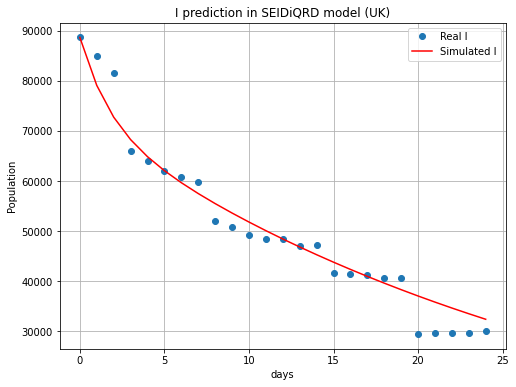

In [278]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,25),r2_i,'o',label = 'Real I')
plt.plot(np.arange(0,25),infect,'r-',label='Simulated I')
plt.grid()
plt.xlabel('days')
plt.ylabel('Population')
plt.title('I prediction in SEIDiQRD model (UK)')
plt.legend()
plt.show()


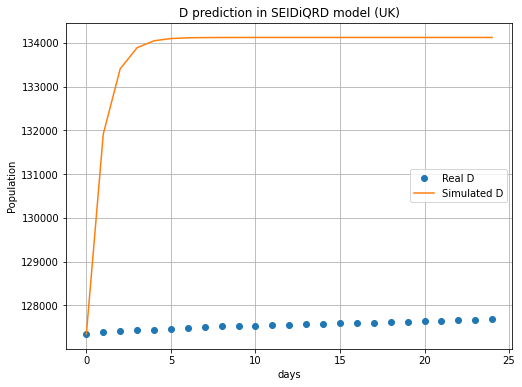

In [279]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,25),r2_d,'o',label = 'Real D')
plt.plot(np.arange(0,25),death,label='Simulated D')
plt.grid()
plt.xlabel('days')
plt.ylabel('Population')
plt.title('D prediction in SEIDiQRD model (UK)')
plt.legend()
plt.show()


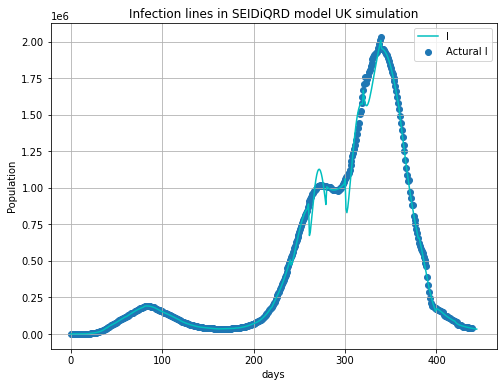

In [171]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,445),total_i,'c-',label = 'I')
plt.scatter(np.arange(0,440),Ilist_i,label='Actural I')
plt.grid()
plt.xlabel('days')
plt.ylabel('Population')
plt.title('Infection lines in SEIDiQRD model UK simulation')
plt.legend()
plt.show()

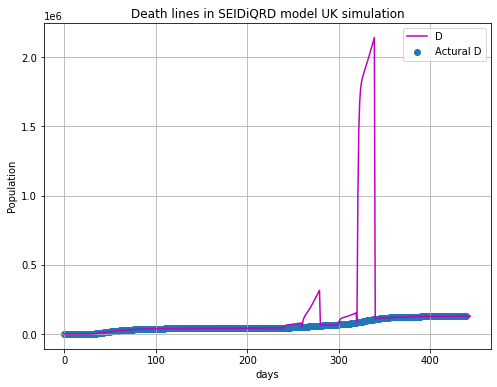

In [172]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,445),total_d,'m-',label = 'D')
plt.scatter(np.arange(0,440),Dlist_i,label='Actural D')
plt.grid()
plt.xlabel('days')
plt.ylabel('Population')
plt.title('Death lines in SEIDiQRD model UK simulation')
plt.legend()
plt.show()

## Sensitivity tests with Italy data

In [332]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [400]:
I0 = Ilist_i[20]
E0 = I0*5
Di0 = I0*0.8
Q0 = Di0*0.7
R0 = Rlist_i[20]
D0 = Dlist_i[20]
population = 150000
S0 = population - E0 - I0 - Di0 - Q0 - D0 - R0

In [527]:
# From Italy simulation with first 20 days
# Changing beta
# italy government announced the "stay at home" regulation during March, 2020

beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=2.33198968,0.67278914 ,1.         ,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015        
N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret.T

In [528]:
# If there was less restrictions of social distancing, higher beta

beta,delta,mu,kappa,epsilon,gamma,sigma,lamb = 2.33198968*1.2,0.67278914 ,1.         ,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015
N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret12 = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret12.T

In [529]:
# If there was completely no regulations of social distancing, much higher beta

beta,delta,mu,kappa,epsilon,gamma,sigma,lamb = 2.33198968*2,0.67278914 ,1.         ,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015

N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret2 = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret2.T

In [530]:
# If there was a tighter social distancing regulation, lower beta

beta,delta,mu,kappa,epsilon,gamma,sigma,lamb = 2.33198968*0.8,0.67278914 ,1.         ,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015

N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret8 = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret8.T

In [531]:
# If there was a strict quarantine restriction, much lower beta

beta,delta,mu,kappa,epsilon,gamma,sigma,lamb = 2.33198968*0.5,0.67278914 ,1.         ,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015
N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret5 = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret5.T

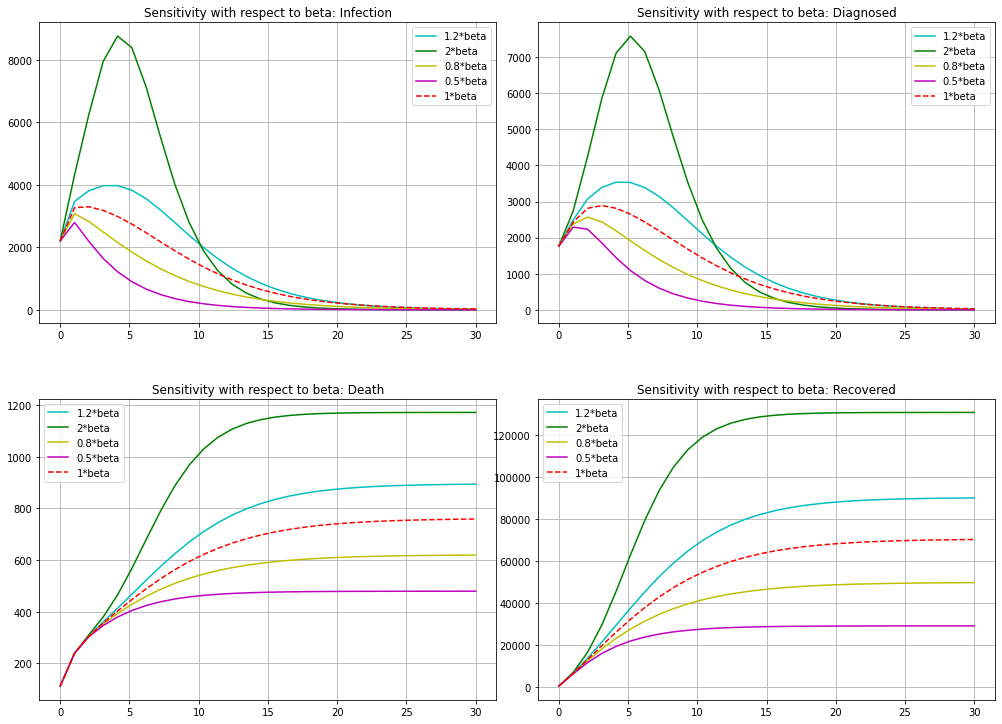

In [532]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.25)

ax0 = axes[0,0]
ax0.plot(t,ret12[:,2],'c-',label='1.2*beta')
ax0.plot(t,ret2[:,2],'g-',label='2*beta')
ax0.plot(t,ret8[:,2],'y-',label='0.8*beta')
ax0.plot(t,ret5[:,2],'m-',label='0.5*beta')
ax0.plot(t,ret[:,2],'r--',label = '1*beta')
ax0.set_title('Sensitivity with respect to beta: Infection')
ax0.legend()
ax0.grid()

ax1 = axes[0,1]
ax1.plot(t,ret12[:,3],'c-',label='1.2*beta')
ax1.plot(t,ret2[:,3],'g-',label='2*beta')
ax1.plot(t,ret8[:,3],'y-',label='0.8*beta')
ax1.plot(t,ret5[:,3],'m-',label='0.5*beta')
ax1.plot(t,ret[:,3],'r--',label = '1*beta')
ax1.set_title('Sensitivity with respect to beta: Diagnosed')
ax1.legend()
ax1.grid()

ax2 = axes[1,0]
ax2.plot(t,ret12[:,5],'c-',label='1.2*beta')
ax2.plot(t,ret2[:,5],'g-',label='2*beta')
ax2.plot(t,ret8[:,5],'y-',label='0.8*beta')
ax2.plot(t,ret5[:,5],'m-',label='0.5*beta')
ax2.plot(t,ret[:,5],'r--',label = '1*beta')
ax2.set_title('Sensitivity with respect to beta: Death')
ax2.legend()
ax2.grid()

ax3 = axes[1,1]
ax3.plot(t,ret12[:,6],'c-',label='1.2*beta')
ax3.plot(t,ret2[:,6],'g-',label='2*beta')
ax3.plot(t,ret8[:,6],'y-',label='0.8*beta')
ax3.plot(t,ret5[:,6],'m-',label='0.5*beta')
ax3.plot(t,ret[:,6],'r--',label = '1*beta')
ax3.set_title('Sensitivity with respect to beta: Recovered')
ax3.legend()
ax3.grid()

In [515]:
# Changing delta
beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=2.33198968 ,0.67278914 ,1.         ,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015
N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret.T

In [521]:
beta,delta,mu,kappa,epsilon,gamma,sigma,lamb = beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=2.33198968 ,0.67278914*1.2,1.         ,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015
N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret12 = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret12.T

In [522]:
beta,delta,mu,kappa,epsilon,gamma,sigma,lamb = beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=2.33198968 ,0.67278914*2,1.         ,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015
N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret2 = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret2.T

In [523]:
beta,delta,mu,kappa,epsilon,gamma,sigma,lamb = beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=2.33198968 ,0.67278914*0.8,1.         ,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015
N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret8 = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret8.T

In [524]:
beta,delta,mu,kappa,epsilon,gamma,sigma,lamb = beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=2.33198968 ,0.67278914*0.5,1.         ,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015
N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret5 = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret5.T

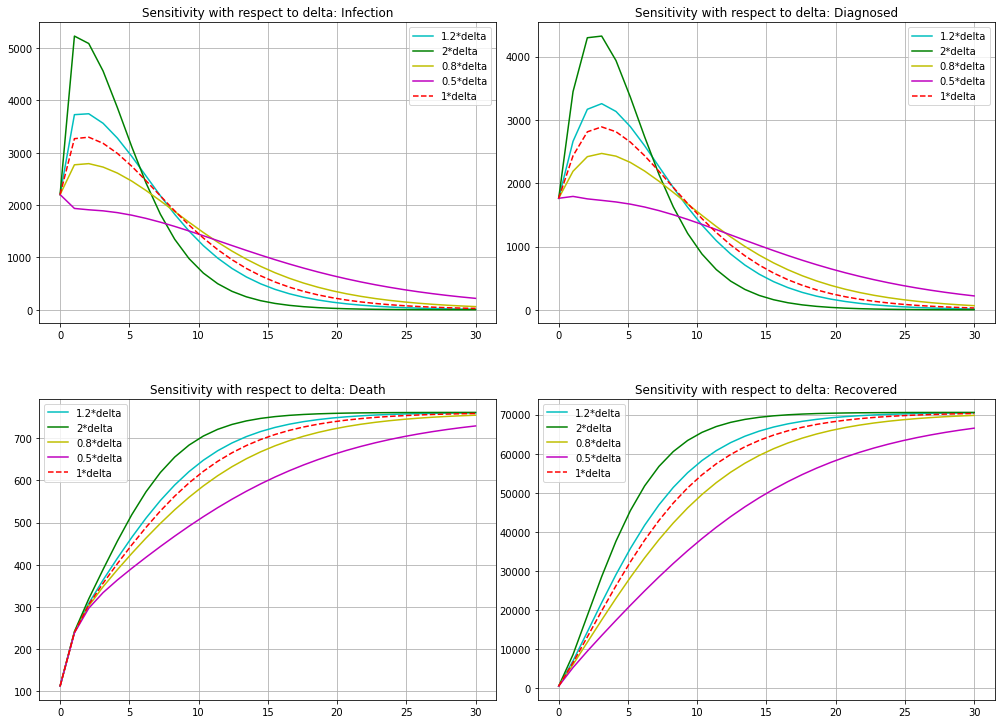

In [526]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.25)

ax0 = axes[0,0]
ax0.plot(t,ret12[:,2],'c-',label='1.2*delta')
ax0.plot(t,ret2[:,2],'g-',label='2*delta')
ax0.plot(t,ret8[:,2],'y-',label='0.8*delta')
ax0.plot(t,ret5[:,2],'m-',label='0.5*delta')
ax0.plot(t,ret[:,2],'r--',label = '1*delta')
ax0.set_title('Sensitivity with respect to delta: Infection')
ax0.legend()
ax0.grid()

ax1 = axes[0,1]
ax1.plot(t,ret12[:,3],'c-',label='1.2*delta')
ax1.plot(t,ret2[:,3],'g-',label='2*delta')
ax1.plot(t,ret8[:,3],'y-',label='0.8*delta')
ax1.plot(t,ret5[:,3],'m-',label='0.5*delta')
ax1.plot(t,ret[:,3],'r--',label = '1*delta')
ax1.set_title('Sensitivity with respect to delta: Diagnosed')
ax1.legend()
ax1.grid()

ax2 = axes[1,0]
ax2.plot(t,ret12[:,5],'c-',label='1.2*delta')
ax2.plot(t,ret2[:,5],'g-',label='2*delta')
ax2.plot(t,ret8[:,5],'y-',label='0.8*delta')
ax2.plot(t,ret5[:,5],'m-',label='0.5*delta')
ax2.plot(t,ret[:,5],'r--',label = '1*delta')
ax2.set_title('Sensitivity with respect to delta: Death')
ax2.legend()
ax2.grid()

ax3 = axes[1,1]
ax3.plot(t,ret12[:,6],'c-',label='1.2*delta')
ax3.plot(t,ret2[:,6],'g-',label='2*delta')
ax3.plot(t,ret8[:,6],'y-',label='0.8*delta')
ax3.plot(t,ret5[:,6],'m-',label='0.5*delta')
ax3.plot(t,ret[:,6],'r--',label = '1*delta')
ax3.set_title('Sensitivity with respect to delta: Recovered')
ax3.legend()
ax3.grid()

In [509]:
# Changing mu      
beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=2.33198968 ,0.67278914 ,1.         ,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015  

N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret.T

In [510]:

#beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=0.51018104, 0.09473496, 0.00597988*1.2, 1.        , 1.        ,0.03720044, 0.00676768, 0.        
beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=2.33198968 ,0.67278914 ,1.         *1.2,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015
N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret12 = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret12.T

In [511]:

#beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=0.51018104, 0.09473496, 0.00597988*2, 1.        , 1.        ,0.03720044, 0.00676768, 0.        
beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=2.33198968 ,0.67278914 ,1.         *2,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015
N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret2 = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret2.T

In [512]:

#beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=0.51018104, 0.09473496, 0.00597988*0.8, 1.        , 1.        ,0.03720044, 0.00676768, 0.        
beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=2.33198968 ,0.67278914 ,1.         *0.8,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015
N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret8 = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret8.T

In [513]:
beta,delta,mu,kappa,epsilon,gamma,sigma,lamb=2.33198968 ,0.67278914 ,1.         *0.5,0.11050382,0.1520071 ,0.96802753,1.         ,0.996015
N = 150000
t = np.linspace(0, 30, 30)


def deriv(y, t, N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb):
    S,E,I,Di,Q,R,D = y
    N = 150000
    dS = - beta * S * I / N 
    dE = beta * S * I / N  - delta * E
    dI = delta * E - mu * I - sigma * I
    dDi = mu * I - kappa * Di - lamb * Di
    dQ = kappa * Di - epsilon * Q - gamma * Q
    dD = epsilon * Q
    dR = gamma * Q + sigma * I + lamb * Di
    return dS,dE,dI,dDi,dQ,dD,dR

# Initial conditions vector
y0 = S0, E0, I0, Di0, Q0, D0, R0
# Integrate the equations over the time grid, t.
ret5 = odeint(deriv, y0, t, args=(N, beta,delta,mu,kappa,epsilon,gamma,sigma,lamb))
S, E, I, Di, Q, D, R = ret5.T

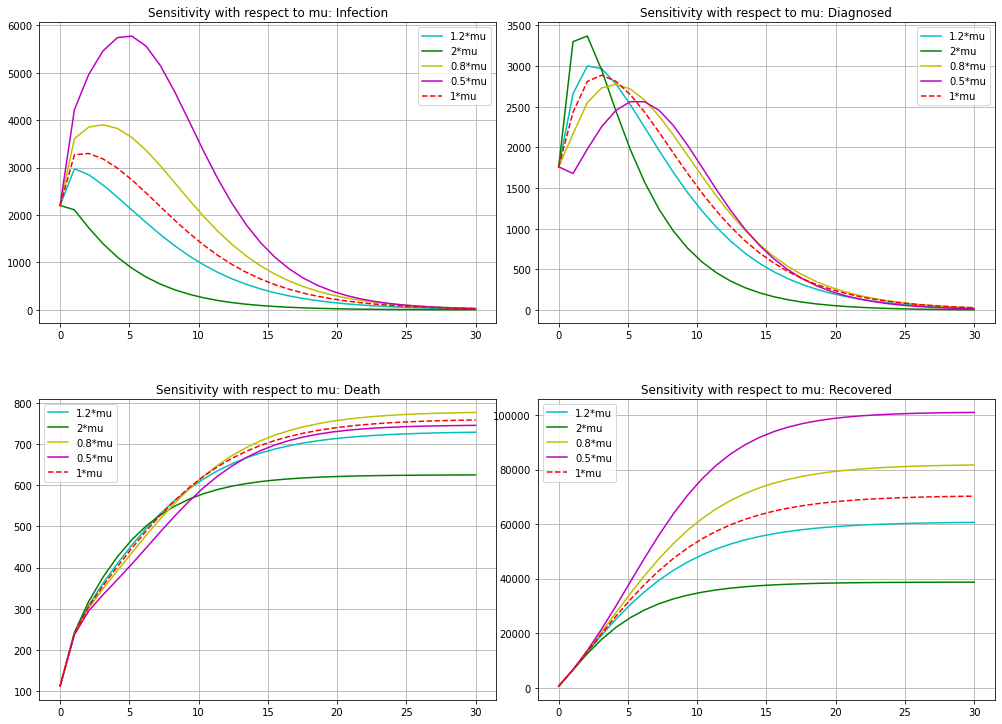

In [514]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.25)

ax0 = axes[0,0]
ax0.plot(t,ret12[:,2],'c-',label='1.2*mu')
ax0.plot(t,ret2[:,2],'g-',label='2*mu')
ax0.plot(t,ret8[:,2],'y-',label='0.8*mu')
ax0.plot(t,ret5[:,2],'m-',label='0.5*mu')
ax0.plot(t,ret[:,2],'r--',label = '1*mu')
ax0.set_title('Sensitivity with respect to mu: Infection')
ax0.legend()
ax0.grid()

ax1 = axes[0,1]
ax1.plot(t,ret12[:,3],'c-',label='1.2*mu')
ax1.plot(t,ret2[:,3],'g-',label='2*mu')
ax1.plot(t,ret8[:,3],'y-',label='0.8*mu')
ax1.plot(t,ret5[:,3],'m-',label='0.5*mu')
ax1.plot(t,ret[:,3],'r--',label = '1*mu')
ax1.set_title('Sensitivity with respect to mu: Diagnosed')
ax1.legend()
ax1.grid()

ax2 = axes[1,0]
ax2.plot(t,ret12[:,5],'c-',label='1.2*mu')
ax2.plot(t,ret2[:,5],'g-',label='2*mu')
ax2.plot(t,ret8[:,5],'y-',label='0.8*mu')
ax2.plot(t,ret5[:,5],'m-',label='0.5*mu')
ax2.plot(t,ret[:,5],'r--',label = '1*mu')
ax2.set_title('Sensitivity with respect to mu: Death')
ax2.legend()
ax2.grid()

ax3 = axes[1,1]
ax3.plot(t,ret12[:,6],'c-',label='1.2*mu')
ax3.plot(t,ret2[:,6],'g-',label='2*mu')
ax3.plot(t,ret8[:,6],'y-',label='0.8*mu')
ax3.plot(t,ret5[:,6],'m-',label='0.5*mu')
ax3.plot(t,ret[:,6],'r--',label = '1*mu')
ax3.set_title('Sensitivity with respect to mu: Recovered')
ax3.legend()
ax3.grid()